In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = './ColorectalCancer'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import torch.nn as nn
from torchvision import models


class CustomResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False)  
        self.features = nn.Sequential(*list(resnet.children())[:-1])  
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

model = CustomResNet18(num_classes=3).to(device)


c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

       
        outputs = model(images)
        loss = criterion(outputs, labels)

       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= train_total


    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}%")




torch.save(model.state_dict(), 'final_custom_resnet18.pth')
print("Final model saved.")

torch.save(model.features.state_dict(), 'final_feature_resnet18.pth')
print("Final feature model saved.")


Epoch [1/10], Train Loss: 0.7072, Train Acc: 71.58%, Test Loss: 0.6125, Test Acc: 72.75%
Epoch [2/10], Train Loss: 0.4677, Train Acc: 82.44%, Test Loss: 0.7407, Test Acc: 71.17%
Epoch [3/10], Train Loss: 0.3778, Train Acc: 85.65%, Test Loss: 1.0388, Test Acc: 64.75%
Epoch [4/10], Train Loss: 0.3128, Train Acc: 88.33%, Test Loss: 0.9071, Test Acc: 72.58%
Epoch [5/10], Train Loss: 0.2730, Train Acc: 89.44%, Test Loss: 0.3353, Test Acc: 86.17%
Epoch [6/10], Train Loss: 0.2684, Train Acc: 90.69%, Test Loss: 0.5876, Test Acc: 74.83%
Epoch [7/10], Train Loss: 0.2547, Train Acc: 90.46%, Test Loss: 0.5849, Test Acc: 80.58%
Epoch [8/10], Train Loss: 0.2143, Train Acc: 92.38%, Test Loss: 0.5393, Test Acc: 80.17%
Epoch [9/10], Train Loss: 0.2141, Train Acc: 91.98%, Test Loss: 0.2784, Test Acc: 89.00%
Epoch [10/10], Train Loss: 0.2000, Train Acc: 92.73%, Test Loss: 0.2214, Test Acc: 91.58%
Final model saved.
Final feature model saved.


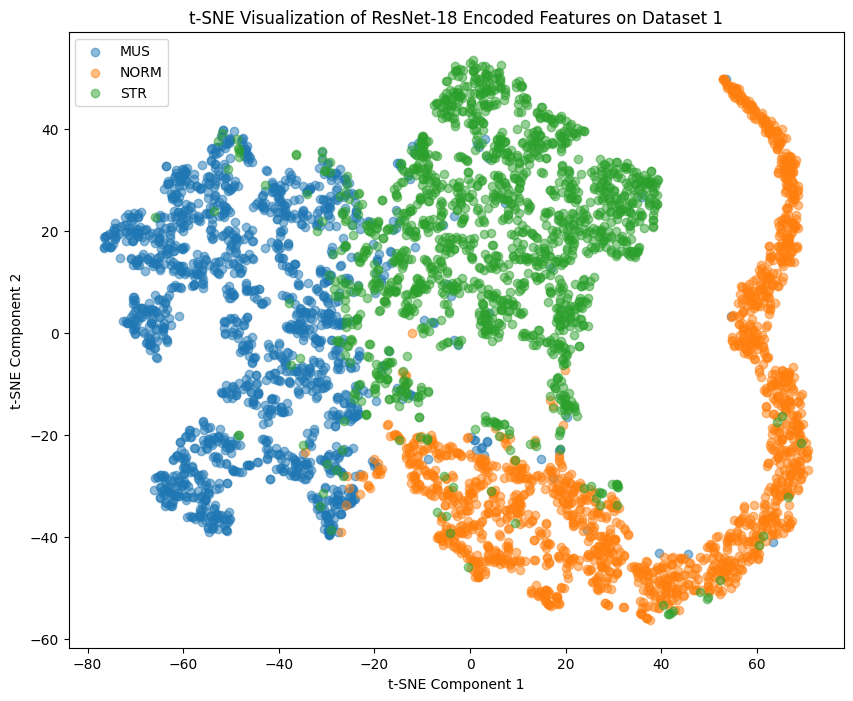

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def extract_features(data_loader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model.features(images)
            features.append(output.view(output.size(0), -1).cpu().numpy())
            labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


train_features, train_labels = extract_features(train_loader, model)

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(train_features)

plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    idx = train_labels == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=dataset.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of ResNet-18 Encoded Features on Dataset 1")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
